In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pywt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sleep_data import SleepDataMASS
from sleep_data import utils

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
dataset = SleepDataMASS(load_from_checkpoint=True)


Loading MASS from checkpoint

Pages in train set: 5838
Pages in val set: 1869
Pages in test set: 3094

Pages in MASS dataset: 10801


In [4]:
subset_name = "val"

fs = dataset.get_fs()
signals, exp_1_marks = dataset.get_augmented_numpy_subset(subset_name, 1, 0)
_, exp_2_marks = dataset.get_augmented_numpy_subset(subset_name, 2, 0)
size_half_page = int(signals.shape[1]/4)
signals = signals[:, size_half_page:-size_half_page]
exp_1_marks = exp_1_marks[:, size_half_page:-size_half_page:10]
exp_2_marks = exp_2_marks[:, size_half_page:-size_half_page:10]
print("Signal", signals.shape)
print("Expert marks", exp_1_marks.shape, exp_2_marks.shape)

nn_marks = np.loadtxt("falcondata/marks_ppt3/predictions_"+subset_name+"_central.csv")
print("NN marks", nn_marks.shape)

n_pages = exp_1_marks.shape[0]

Signal (1869, 4000)
Expert marks (1869, 400) (1869, 400)
NN marks (1869, 400)


In [5]:
# Binarize the nn output with 0.5 thr

nn_marks_bin = (nn_marks > 0.5).astype(int)

# Split the marks and prediction by register
if subset_name == 'val':
    single_npages = [496, 638, 735]
elif subset_name == 'test': 
    single_npages = [911, 676, 689, 818]
else:
    raise ValueError("Only 'val' or 'test' is supported.")
    
splitted = []
for k in range(len(single_npages)):
    start = sum(single_npages[:k]) if k>0 else 0
    end = sum(single_npages[:k+1])
    splitted.append(
       {
           'e1': exp_1_marks[start:end, :],
           'e2': exp_2_marks[start:end, :],
           'nn': nn_marks_bin[start:end, :]
       }
       )
    

In [6]:
# Filter nn_marks

reduction_factor = exp_1_marks.shape[1] / signals.shape[1]
# print(reduction_factor)

for r in range(len(splitted)):
    print("")
    this_nn = np.copy(splitted[r]['nn'])
    original_page = this_nn.shape[1]
    # print(this_nn.shape)
    this_nn_c = np.concatenate(this_nn)
    original_length = this_nn_c.shape[0]
    # print(this_nn_c.shape)
    # convert to intervals
    this_nn_inter = utils.seq2inter(this_nn_c)
    # print(this_nn_inter.shape)
    
    # combine too close marks
    marks = this_nn_inter
    print("original marks shape", marks.shape)
    new_marks = np.copy(marks[0, :])
    new_marks = new_marks[np.newaxis, :]
    # print("initial new marks shape", new_marks.shape)
    for k in range(1, marks.shape[0]):
        distance = (marks[k, 0] - new_marks[-1, 1] - 1) / (fs * reduction_factor)
        # Too close -> combine
        if distance <= 0.3:
            new_marks[-1, 1] = marks[k, 1]
        # If not, add it
        else:
            new_marks = np.append(new_marks, marks[k:k+1,:], axis=0)
    print("after combination shape", new_marks.shape)
    
    # Remove too shorts / too long marks
    duration = np.squeeze((np.diff(new_marks) + 1) / (fs * reduction_factor))
    too_short = duration < 0.2
    too_long = duration > 4
    new_marks = new_marks[ np.invert(too_short) & np.invert(too_long), :]
    print("too_short", sum(too_short.astype(int)), "too_long", sum(too_long.astype(int)))
    print("after removing shape", new_marks.shape)

    print(new_marks[0,:])
    # Go back to interval
    this_nn_filtered_c = utils.inter2seq(new_marks, 0, original_length - 1)
    # print(this_nn_filtered_c.shape)
    this_nn_filtered = np.reshape(this_nn_filtered_c, (-1, original_page))
    print(this_nn_filtered.shape)
    splitted[r]['nn'] = this_nn_filtered


original marks shape (102, 2)
after combination shape (100, 2)
too_short 9 too_long 0
after removing shape (91, 2)
[3003 3016]
(496, 400)

original marks shape (883, 2)
after combination shape (855, 2)
too_short 16 too_long 0
after removing shape (839, 2)
[674 689]
(638, 400)

original marks shape (1880, 2)
after combination shape (1808, 2)
too_short 98 too_long 1
after removing shape (1709, 2)
[4310 4313]
(735, 400)


In [7]:
# By-sample statistics

print("By Sample Stats")
bs_stats = []
acc_tp = 0
acc_fp = 0
acc_fn = 0
for reg in splitted:
    this_nn = reg['nn']
    this_e1 = reg['e1']
    tp = np.sum((this_nn == 1) & (this_e1 == 1))
    fp = np.sum((this_nn == 1) & (this_e1 == 0))
    fn = np.sum((this_nn == 0) & (this_e1 == 1))
    acc_tp += tp
    acc_fp += fp
    acc_fn += fn
    print("")
    print("TP: %d, FP: %d, FN: %d" % (tp, fp, fn))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print("Precision %1.4f, Recall %1.4f, F1-score %1.4f" % (precision, recall, f1))
    bs_stats.append({'precision': precision, 'recall': recall})
print("")
print("Total -- TP: %d, FP: %d, FN: %d" % (acc_tp, acc_fp, acc_fn))
acc_precision = acc_tp/(acc_tp+acc_fp)
acc_recall = acc_tp/(acc_tp+acc_fn)
acc_f1 = 2 * acc_precision * acc_recall / (acc_precision + acc_recall)
print("Total -- Precision %1.4f, Recall %1.4f, F1-score %1.4f" % (acc_precision, acc_recall, acc_f1))

By Sample Stats

TP: 994, FP: 227, FN: 964
Precision 0.8141, Recall 0.5077, F1-score 0.6254

TP: 9486, FP: 4771, FN: 1714
Precision 0.6654, Recall 0.8470, F1-score 0.7453

TP: 8060, FP: 18861, FN: 11482
Precision 0.2994, Recall 0.4124, F1-score 0.3469

Total -- TP: 18540, FP: 23859, FN: 14160
Total -- Precision 0.4373, Recall 0.5670, F1-score 0.4937


In [8]:
def matching(detections, events, IoU_thr):
    det = np.sort(detections, axis=0)
    gs = np.sort(events, axis=0)
    
    # Matrix of overlap, rows are gs, columns are det
    n_det = det.shape[0]
    n_gs = gs.shape[0]
    overlaps = np.zeros((n_gs, n_det))
    for i in range(n_gs):
        for j in range(n_det):
            inter_samples = np.arange(max( gs[i,0], det[j,0]), min( gs[i,1], det[j,1]) + 1)
            if inter_samples.size > 0:
                intersection = inter_samples.size
                union_samples =  np.arange(min( gs[i,0], det[j,0]), max( gs[i,1], det[j,1]) + 1)
                union = union_samples.size
                overlaps[i, j] = intersection / union
    
    # Greedy matching
    IoU_array = []  # Array for IoU for every true event (gs)
    for i in range(n_gs):
        if np.sum(overlaps[i, :]) > 0:
            # Find max overlap
            max_j = np.argmax(overlaps[i, :])
            IoU_array.append(overlaps[i, max_j])
            # Remove this detection for further search
            overlaps[i, max_j] = 0
        else:
            IoU_array.append(0)
    IoU_array = np.array(IoU_array)        
 
    # Now assign TP according to thr
    tp = sum((IoU_array >= IoU_thr).astype(int))
    
    return tp, IoU_array

By Event Stats at IoU 0.20

TP: 75, D: 91, E: 140
Precision 0.8242, Recall 0.5357, F1-score 0.6494


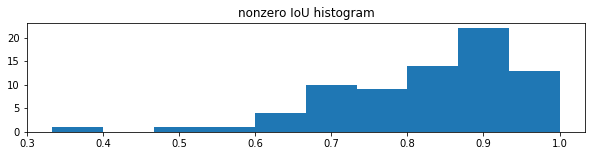


TP: 562, D: 839, E: 602
Precision 0.6698, Recall 0.9336, F1-score 0.7800


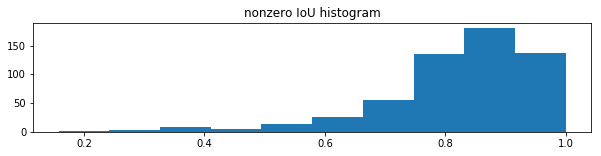


TP: 618, D: 1709, E: 1152
Precision 0.3616, Recall 0.5365, F1-score 0.4320


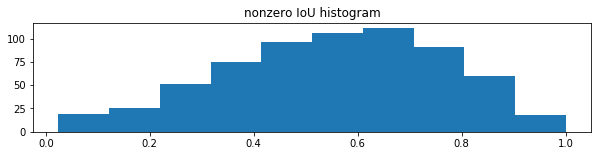


Total -- TP: 1255, D: 2639, E: 1894
Total -- Precision 0.4756, Recall 0.6626, F1-score 0.5537


In [23]:
# By event statistics
IoU_thr = 0.2
print("By Event Stats at IoU %1.2f" % (IoU_thr,))

be_stats = []
acc_tp = 0
acc_detection = 0
acc_event = 0
acc_IoU = []
for reg in splitted:
    this_nn = reg['nn']
    this_e1 = reg['e1']
    
    this_nn_inter = utils.seq2inter(np.concatenate(this_nn))
    this_e1_inter = utils.seq2inter(np.concatenate(this_e1))
    
    n_detection = this_nn_inter.shape[0]
    n_event = this_e1_inter.shape[0]
    
    tp, IoU_array = matching(this_nn_inter, this_e1_inter, IoU_thr)

    acc_IoU.append(IoU_array)

    acc_tp += tp
    acc_detection += n_detection
    acc_event += n_event
    print("")
    print("TP: %d, D: %d, E: %d" % (tp, n_detection, n_event))
    precision = tp / n_detection
    recall = tp / n_event
    f1 = 2 * precision * recall / (precision + recall)
    print("Precision %1.4f, Recall %1.4f, F1-score %1.4f" % (precision, recall, f1))
    be_stats.append({'precision': precision, 'recall': recall})
    
    # Show histogram of IoU > 0 
    fig = plt.figure(figsize=(10,2))
    plt.hist(IoU_array[IoU_array>0])
    plt.title('nonzero IoU histogram')
    plt.show()
    
acc_IoU = np.concatenate(acc_IoU)

print("")
print("Total -- TP: %d, D: %d, E: %d" % (acc_tp, acc_detection, acc_event))
acc_precision = acc_tp / acc_detection
acc_recall = acc_tp / acc_event
acc_f1 = 2 * acc_precision * acc_recall / (acc_precision + acc_recall)
print("Total -- Precision %1.4f, Recall %1.4f, F1-score %1.4f" % (acc_precision, acc_recall, acc_f1))

# Show histogram of IoU
# fig = plt.figure(figsize=(10,2))
# plt.hist(acc_IoU[acc_IoU>0])
# plt.title('Total nonzero IoU histogram')
# plt.show()

In [10]:
# Generate postprocessed output of NN for plot
nn_marks_post = [reg['nn'] for reg in splitted]
nn_marks_post = np.concatenate(nn_marks_post, axis=0)

In [17]:
import tensorflow as tf

from models import cwt_ops

tf.reset_default_graph()

input_ph = tf.placeholder(dtype=tf.float32, shape=(None, 4000), name="segment_ph")

wavelets, _ = cwt_ops.complex_morlet_wavelets(
        fb_array=np.array([1.5]),
        fs=fs,
        lower_freq=3,
        upper_freq=40,
        n_scales=32,
        flattening=True)

scalograms = cwt_ops.cwt_layer(
        inputs=input_ph,
        wavelets=wavelets,
        border_crop=0,
        stride=1,
        data_format="channel_last",
        name="cwt_module")

sess = tf.Session()

In [11]:
def set_cwt(fs):
    # Parameters CWT
    fb = 1.5
    lower_freq = 3
    upper_freq = 40
    n_scales = 32
    # Generate initial and last scale
    s_0 = fs / upper_freq
    s_n = fs / lower_freq
    # Generate the array of scales
    base = np.power(s_n / s_0, 1 / (n_scales - 1))
    scales = s_0 * np.power(base, np.arange(n_scales))
    # Pywavelets
    w = pywt.ContinuousWavelet('cmor')
    w.center_frequency = 1
    w.bandwidth_frequency = fb
    return scales, w

In [12]:
def get_cwt(segment, scales, w, fs):
    coef, freqs = pywt.cwt(segment, scales, w, 1/fs)
    abs_coef = np.abs(coef)
    return abs_coef * freqs[:, np.newaxis]

In [22]:
def plot_page(page):
    global signals, exp_marks, nn_marks, nn_marks_post, fs
    fig = plt.figure(figsize=(25, 9)) 
    gs = gridspec.GridSpec(6, 1, height_ratios=[4, 6, 1, 1, 1, 1]) 
    
    time_axis = np.arange(0, signals.shape[1])/fs
    this_signal = signals[page, :]
    this_mark_1 = exp_1_marks[page, :]
    this_mark_2 = exp_2_marks[page, :]
    this_pred = nn_marks[page, :]
    this_pred_post = nn_marks_post[page, :]
    # scales, w = set_cwt(fs)
    # this_cwt = get_cwt(this_signal, scales, w, fs)
    this_cwt = sess.run(scalograms, feed_dict={input_ph: np.array([this_signal])})
    this_cwt = (np.squeeze(this_cwt)).T
    
    # Signal
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(time_axis, this_signal)
    ax0.set_yticks([])
    ax0.set_xlim([0, 20])
    ax0.set_ylim([-4, 4])
    ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown)')
    ax0.set_xticks([0, 5, 10, 15, 20])
    ax0.set_xticks(np.arange(0, 20, 0.5), minor=True)
    ax0.grid(b=True, axis='x', which='minor')
    
    # CWT (con Pywavelets)
    ax1 = fig.add_subplot(gs[1])
    ax1.imshow(this_cwt, interpolation=None, aspect='auto', extent=[1, 20, 32, 1])
    ax1.axis('off')
    ax1.set_title('CWT CMorlet, [3, 40] Hz, Fb = 1.5')
    
    # Expert mark
    ax2 = fig.add_subplot(gs[2])
    ax2.imshow(this_mark_1[np.newaxis, :], interpolation=None, aspect='auto', extent=[1, 20, 32, 1])
    ax2.axis('off')
    ax2.set_title('Expert 1')
    
    ax3 = fig.add_subplot(gs[3])
    ax3.imshow(this_mark_2[np.newaxis, :], interpolation=None, aspect='auto', extent=[1, 20, 32, 1])
    ax3.axis('off')
    ax3.set_title('Expert 2')
    
    # NN mark
    ax4 = fig.add_subplot(gs[4])
    ax4.imshow(this_pred[np.newaxis, :], interpolation=None, aspect='auto', extent=[1, 20, 32, 1])
    ax4.axis('off')
    ax4.set_title('Raw Neural Net Output')
    
    ax4 = fig.add_subplot(gs[5])
    ax4.imshow(this_pred_post[np.newaxis, :], interpolation=None, aspect='auto', extent=[1, 20, 32, 1])
    ax4.axis('off')
    ax4.set_title('Post-Processed Neural Net Output')
    
    plt.tight_layout()
    plt.show()

interact(plot_page, page=widgets.IntSlider(min=1,max=n_pages,step=1,value=1, continuous_update=False));


interactive(children=(IntSlider(value=1, continuous_update=False, description='page', max=1869, min=1), Output…